## Caplet Volatility Bootstrapping

From the prices of different maturity caps, it is possible to **bootstrap** the volatility of each caplet, i.e. the volatility which refers to the forward rate corresponding to the caplet.

### Example
Let's *strip* caplet volatilities from the following cap (flat) vol

 Maturity | Volatility
--------|-------
1y  | 44\%
2y  | 45\%
3y  | 44\%
4y  | 41\%
5y  | 39\%

The quoted volatilities refer to caps with 0.013 strike over EURIBOR-6M

 Pillar | Rate
--------|-------
3m  | 0.0002
6m  | 0.0007
12m | 0.0025
2y  | 0.0070
3y  | 0.0100
5y  | 0.0162

1. We start with the nearest instruments, i.e. the spot starting caplet with $6m$ maturity. For maturities shorter than the first quoted value we consider the volatility constant hence:
$$\sigma^{spot}_{6m}= \sigma^{spot}_{6m,1y} = \color{green}{\sigma^{flat}_{1y}}$$

directly known from the market quote of $\textbf{Cap}_{1y}(\textcolor{green}{\sigma^{flat}_{1y}})$.

2. Let’s now price the $1y$ forward starting caplet with $6m$ maturity. Since market cap volatilities are quoted assuming **no-arbitrage** opportunity we can build the forward starting caplet as the difference of two caps:

\begin{equation}
\begin{gathered}
\textbf{Cpl}_{1y,1y6m}(\sigma^{spot}_{1y6m})=\textbf{Cap}_{1y6m}-\textbf{Cap}_{1y} \\[0.3cm]
\textbf{Cap}_{1y6m}=\textbf{Cpl}_{6m}(\textcolor{red}{\sigma^{flat}_{1y6m}}) + \textbf{Cpl}_{6m,1y}(\textcolor{red}{\sigma^{flat}_{1y6m}}) + \textbf{Cpl}_{1y,1y6m}(\textcolor{red}{\sigma^{flat}_{1y6m}}) \\[0.3cm]
\textbf{Cap}_{1y}=\textbf{Cpl}_{6m}(\textcolor{green}{\sigma^{flat}_{1y}}) + \textbf{Cpl}_{6m,1y}(\textcolor{green}{\sigma^{flat}_{1y}})
\end{gathered}
\end{equation}

Unfortunately the $18m$ volatility is NOT quoted on the market, so we can:
  * assume for the sake of simplicity that the volatility remains constant between $1y$ and $2y$ caps;
  * use an interpolation method such as linear or cubic spline to get the $1y6m$ cap volatility.


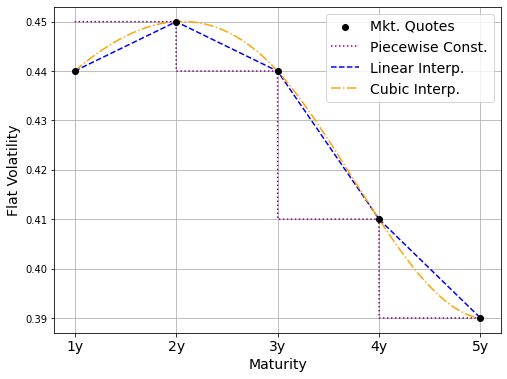

Once "estimated" $\sigma^{flat}_{1y6m}$ we will be able to solve a single volatility from previous Equation by using Newton-Raphson or Brent method.

3. We can apply the same method for the $1y6m$ forward starting caplet to get the volatility, $\sigma^{flat}_{2y}$ is quoted so no interpolation is needed here.

\begin{equation}
\begin{gathered}
\textbf{Cpl}_{1y6m,2y}(\sigma^{spot}_{2y})=\textbf{Cap}_{2y}-\textbf{Cap}_{1y6m} \\[0.3cm]
\textbf{Cap}_{2y}=\textbf{Cpl}_{6m}(\textcolor{green}{\sigma^{flat}_{2y}}) + \textbf{Cpl}_{6m,1y}(\textcolor{green}{\sigma^{flat}_{2y}}) + \ldots + \textbf{Cpl}_{1y6m,2y}(\textcolor{green}{\sigma^{flat}_{2y}}) \\[0.3cm]
\textbf{Cap}_{1y6m}=\textbf{Cpl}_{6m}(\textcolor{green}{\sigma^{flat}_{1y6m}}) + \textbf{Cpl}_{6m,1y}(\textcolor{green}{\sigma^{flat}_{1y6m}}) + \textbf{Cpl}_{1y,1y6m}(\textcolor{green}{\sigma^{flat}_{1y6m}})
\end{gathered}
\end{equation}

4. Keep iteratively to solve for all the remaining volatilities using the very same technique.

In [1]:
from datetime import date
from dateutil.relativedelta import relativedelta

def TimeInterval(interval):
    tag = interval[-1].lower()
    value = int(interval[:-1])
    if tag == "d":
        return relativedelta(days=value)
    elif tag == "m":
        return relativedelta(months=value)
    elif tag == "y":
        return relativedelta(years=value)
    else:
        raise ValueError(f"Unable to convert {interval}, probably wrong units.")
    
def generate_dates(start_date, end_date, frequency="1y"):
    if isinstance(end_date, str):
        end_date = start_date + TimeInterval(end_date)
    d = start_date
    dates = [start_date]
    while True:
        d += TimeInterval(frequency)
        if d < end_date:
            dates.append(d)
        else:
            dates.append(end_date)
            break
    return dates

In [2]:
import numpy as np

from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d

class DiscountCurve:
    def __init__(self, obs_date, pillar_dates, discount_factors):
        discount_factors = np.array(discount_factors)
        if obs_date not in pillar_dates:
            pillar_dates = [obs_date] + pillar_dates
            discount_factors = np.insert(discount_factors, 0, 1)
        self.pillar_dates = pillar_dates
        self.pillars = [p.toordinal() for p in pillar_dates]
        self.dfs = discount_factors
        self.log_discount_factors = np.log(discount_factors)
        self.interpolator = interp1d(self.pillars, self.log_discount_factors)
        
    def df(self, adate):
        d = adate.toordinal()
        if d < self.pillars[0] or d > self.pillars[-1]:
            raise ValueError(f"Cannot extrapolate discount factors (date: {adate}).")
        return np.exp(self.interpolator(d))

class TermStructure:
    def __init__(self, obs_date, pillars, spot_rates):
        self.obs_date = obs_date
        self.pillars_dates = pillars
        self.pillars = [(p-obs_date).days/365 for p in pillars]
        self.rates = spot_rates
        self.interpolator = interp1d(self.pillars, self.rates)
        
    def interp_rate(self, adate):
        d = (adate-self.obs_date).days/365
        if d < self.pillars[0] or d > self.pillars[-1]:
            raise ValueError(f"Cannot extrapolate rates (date: {adate}).")
        else:
            return d, self.interpolator(d)

    def forward_rate(self, d1, d2):
        d1, r1 = self.interp_rate(d1)
        d2, r2 = self.interp_rate(d2)
        return (r2*d2 - r1*d1)/(d2 - d1)

In [15]:
import numpy as np

from enum import IntEnum
from scipy.stats import norm

CapFloorType = IntEnum("CapFloorType", {"Cap":1, "Floor":-1})

class CapFloorLet:
    def __init__(self, nominal, start_date, maturity, fixed_rate, type=CapFloorType.Cap):
        self.N = nominal
        self.start = start_date
        self.end = start_date + TimeInterval(maturity)
        self.K = fixed_rate
        self.type = type

    def npv(self, sigma, dc, fc):
        tau = (self.end - self.start).days/360
        D = dc.df(self.end)
        F = fc.forward_rate(self.start, self.end)
        Tf = (self.start - dc.pillar_dates[0]).days/360
        v = sigma*np.sqrt(Tf)
        d1 = (np.log(F/self.K)+0.5*v**2)/v
        d2 = (np.log(F/self.K)-0.5*v**2)/v
        if self.type == CapFloorType.Cap:
            return D*(F*norm.cdf(d1)-self.K*norm.cdf(d2))
        else:
            return D(self.K*norm.cdf(-d2)-F*norm.cdf(-d1))

class CapFloor:
    def __init__(self, nominal, start_date, maturity, tenor, K, type=CapFloorType.Cap):
        self.dates = generate_dates(start_date, maturity, tenor)
        self.K = K
        self.type = type
        self.tenor = tenor
        self.N = nominal

    def npv(self, sigma, dc, fc):
        val = 0
        for i in range(0, len(self.dates)-1):
            caplet = CapFloorLet(self.N, self.dates[i], self.tenor, self.K, self.type)
            val += caplet.npv(sigma, dc, fc)
        return val

In [16]:
import numpy as np

from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import newton

from datetime import date
from dateutil.relativedelta import relativedelta

valuation_date = date.today()
rates = np.array([0.02, 0.02, 0.07, 0.25, 0.70, 1.10, 1.62, 2.00])/100
dfs = [1/(1+rates[i])**t for i, t in enumerate([0, 0.25, 0.5, 1, 2, 3, 5, 7])]
pillar_dates = [valuation_date + relativedelta(months=i*12) for i in [0, 0.25, 0.5, 1, 2, 3, 5, 7]]
fc = TermStructure(valuation_date, pillar_dates, rates)
dc = DiscountCurve(valuation_date, pillar_dates, dfs)

cap_maturities = [(valuation_date + TimeInterval(m) - valuation_date).days for m in ["1y", "2y", "3y", "4y", "5y"]]
cap_volatilities = [0.44, 0.45, 0.44, 0.41, 0.39]
vol_interp = interp1d(cap_maturities, cap_volatilities, fill_value='extrapolate', kind='slinear')

ttm = ['6m', "1y", '18m', "2y", '30m', "3y", '42m', "4y", '54m', "5y"]
K = 0.013

def obj_func(sigma, caplet, dc, fc, target_price):
  return caplet.npv(sigma, dc, fc)-target_price

sigmas = []
for i in range(len(ttm)-1):
  ttm_val = (valuation_date + TimeInterval(ttm[i]) - valuation_date).days
  if ttm_val < cap_maturities[0]:
    sigmas.append(cap_volatilities[0])
  else:
    cap0 = CapFloor(1, valuation_date, ttm[i], "6m", K, CapFloorType.Cap)
    cap1 = CapFloor(1, valuation_date, ttm[i+1], "6m", K, CapFloorType.Cap)

    P1 = cap1.npv(vol_interp((valuation_date + TimeInterval(ttm[i+1]) - valuation_date).days), dc, fc)
    P0 = cap0.npv(vol_interp(ttm_val), dc, fc)
    dP = P1 - P0
    caplet = CapFloorLet(1, cap0.dates[-1], "6m", K, CapFloorType.Cap)
    sigma = newton(obj_func, 1, args=(caplet, dc, fc, dP))
    sigmas.append(sigma)

C:\Users\t004672\AppData\Local\Temp\ipykernel_15708\1691624536.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F/self.K)+0.5*v**2)/v
C:\Users\t004672\AppData\Local\Temp\ipykernel_15708\1691624536.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(F/self.K)-0.5*v**2)/v


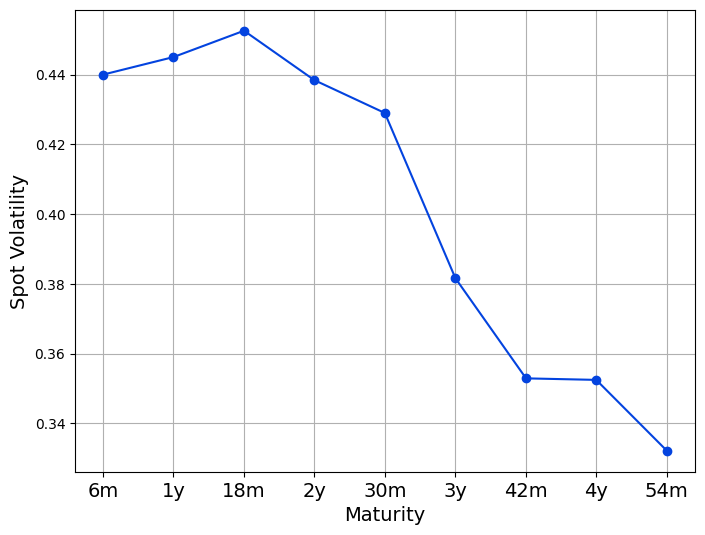

In [17]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (8, 6)
ts = [valuation_date + TimeInterval(ttm[i]) for i in range(len(ttm)-1)]

plt.plot(ts, sigmas, marker="o", color="xkcd:blue")
plt.xticks(ts, ttm[:-1], fontsize=14)
plt.grid(True)
plt.xlabel("Maturity", fontsize=14)
plt.ylabel("Spot Volatility", fontsize=14)
plt.show()